In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = 'drive/MyDrive/nyu_depth_v2_labeled.mat'

In [5]:
import torch.nn as nn
import torch
import os
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
from torchvision import transforms
import argparse
import cv2

In [ ]:
def DEPTH_Calc(xmin,ymin,xmax,ymax):
  xmin = math.floor(xmin)
  ymin = math.floor(ymin)
  xmax = math.floor(xmax)
  ymax = math.floor(ymax)
  sum = 0
  num = 1
  for i in range(xmin,xmax +1):
    for j in range(ymin,ymax +1):
      sum += pred[j,i]
  num = (xmax-xmin+1)*(ymax-ymin+1)
  DEPTH = sum/num
  return DEPTH

In [6]:
f = h5py.File(dataset_path,'r')
depths = f.get('depths')
depths = np.array(depths)
depths= np.transpose(depths, (0,2,1))

In [7]:
images = f.get('images')
images = np.array(images) 
images= np.transpose(images, (0,3,2,1))

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 conv layer with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_incoming_shape(incoming):
    size = incoming.size()
    # returns the incoming data shape as a list
    return [size[0], size[1], size[2], size[3]]


def interleave(tensors, axis):
    # change the first element (batch_size to -1)
    old_shape = get_incoming_shape(tensors[0])[1:]
    new_shape = [-1] + old_shape

    # double 1 dimension
    new_shape[axis] *= len(tensors)

    # pack the tensors on top of each other
    stacked = torch.stack(tensors, axis+1)

    # reshape and return
    reshaped = stacked.view(new_shape)
    return reshaped


class UnpoolingAsConvolution(nn.Module):
    def __init__(self, inplanes, planes):
        super(UnpoolingAsConvolution, self).__init__()

        # interleaving convolutions
        self.conv_A = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 3), stride=1, padding=1)
        self.conv_B = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 3), stride=1, padding=0)
        self.conv_C = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 2), stride=1, padding=0)
        self.conv_D = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 2), stride=1, padding=0)

    def forward(self, x):
        output_a = self.conv_A(x)

        padded_b = nn.functional.pad(x, (1, 1, 0, 1))
        output_b = self.conv_B(padded_b)

        padded_c = nn.functional.pad(x, (0, 1, 1, 1))
        output_c = self.conv_C(padded_c)

        padded_d = nn.functional.pad(x, (0, 1, 0, 1))
        output_d = self.conv_D(padded_d)

        left = interleave([output_a, output_b], axis=2)
        right = interleave([output_c, output_d], axis=2)
        y = interleave([left, right], axis=3)
        return y


class UpProjection(nn.Module):
    def __init__(self, inplanes, planes):
        super(UpProjection, self).__init__()

        self.unpool_main = UnpoolingAsConvolution(inplanes, planes)
        self.unpool_res = UnpoolingAsConvolution(inplanes, planes)

        self.main_branch = nn.Sequential(
            self.unpool_main,
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=False),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )

        self.residual_branch = nn.Sequential(
            self.unpool_res,
            nn.BatchNorm2d(planes),
        )

        self.relu = nn.ReLU(inplace=False)

    def forward(self, input_data):
        x = self.main_branch(input_data)
        res = self.residual_branch(input_data)
        x += res
        x = self.relu(x)
        return x


class ConConv(nn.Module):
    def __init__(self, inplanes_x1, inplanes_x2, planes):
        super(ConConv, self).__init__()
        self.conv = nn.Conv2d(inplanes_x1 + inplanes_x2, planes, kernel_size=1, bias=True)

    def forward(self, x1, x2):
        x1 = torch.cat([x2, x1], dim=1)
        x1 = self.conv(x1)
        return x1


class ResnetUnetHybrid(nn.Module):
    def __init__(self, block, layers):
        self.inplanes = 64

        # resnet layers
        super(ResnetUnetHybrid, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # additional up projection layers parts
        self.conv2 = nn.Conv2d(2048, 1024, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(1024)

        self.up_proj1 = UpProjection(1024, 512)
        self.up_proj2 = UpProjection(512, 256)
        self.up_proj3 = UpProjection(256, 128)
        self.up_proj4 = UpProjection(128, 64)

        self.drop = nn.Dropout(0.5, False)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True)

        # padding + concat for unet stuff
        self.con_conv1 = ConConv(1024, 512, 512)
        self.con_conv2 = ConConv(512, 256, 256)
        self.con_conv3 = ConConv(256, 128, 128)
        self.con_conv4 = ConConv(64, 64, 64)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x_to_conv4 = self.relu(x)

        x = self.maxpool(x_to_conv4)
        x_to_conv3 = self.layer1(x)
        x_to_conv2 = self.layer2(x_to_conv3)
        x_to_conv1 = self.layer3(x_to_conv2)
        x = self.layer4(x_to_conv1)

        # additional layers
        x = self.conv2(x)
        x = self.bn2(x)

        # up project part
        x = self.up_proj1(x)
        x = self.con_conv1(x, x_to_conv1)

        x = self.up_proj2(x)
        x = self.con_conv2(x, x_to_conv2)

        x = self.up_proj3(x)
        x = self.con_conv3(x, x_to_conv3)

        x = self.up_proj4(x)
        x = self.con_conv4(x, x_to_conv4)

        x = self.drop(x)
        x = self.conv3(x)
        x = self.relu(x)

        return x

    @classmethod
    def load_pretrained(cls, device, load_path='hyb_net_weights.model'):
        model = cls(Bottleneck, [3, 4, 6, 3])

        # download the weights if they are not present
        if not os.path.exists(load_path):
            print('Downloading model weights...')
            os.system('wget https://www.dropbox.com/s/amad4ko9opi4kts/hyb_net_weights.model')

        model = model.to(device)
        model.load_state_dict(torch.load(load_path, map_location=device))

        return model


In [9]:
HEIGHT = 256
WIDTH = 320


def scale_image(img, scale=None):
    """Resize/scale an image. If a scale is not provided, scale it closer to HEIGHT x WIDTH."""
    # if scale is None, scale to the longer size
    if scale is None:
        scale = max(WIDTH / img.shape[1], HEIGHT / img.shape[0])

    new_size = (math.ceil(img.shape[1] * scale), math.ceil(img.shape[0] * scale))
    image = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    return image


def center_crop(img):
    """Center crop an image to HEIGHT x WIDTH."""
    corner = ((img.shape[0] - HEIGHT) // 2, (img.shape[1] - WIDTH) // 2)
    img = img[corner[0]:corner[0] + HEIGHT, corner[1]:corner[1] + WIDTH]
    return img


def img_transform(img):
    """Normalize an image."""
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = data_transform(img)
    return img


def show_img_and_pred(img, depth):
    """Plot an image and a corresponding prediction next to each other."""
    plt.figure(figsize = (12 ,6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    pred = np.transpose(depth, (1, 2, 0))
    pred = pred [ : , : , 0]
    plt.imshow(pred ,  cmap=plt.cm.gist_rainbow)

    plt.show()
    


def depth_to_grayscale(depth, max_dist=10.0):
    """Transform a prediction into a grayscale 8-bit image."""
    depth = np.transpose(depth, (1, 2, 0))
    depth[depth > max_dist] = max_dist
    depth = depth / max_dist

    depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR)
    bgr_depth_img = np.clip(bgr_depth_img, 0, 255)
    return bgr_depth_img


In [10]:
def predict_img(img):
    """Inference a single image."""
    # switch to CUDA device if possible
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Use GPU: {}'.format(str(device) != 'cpu'))

    # load model
    print('Loading model...')
    model = ResnetUnetHybrid.load_pretrained(device=device)
    model.eval()

    H = img.shape[1]
    W = img.shape[0]
    img = scale_image(img)
    img = center_crop(img)
    inp = img_transform(img)
    inp = inp[None, :, :, :].to(device)

    # inference
    print('Running the image through the network...')
    output_ = model(inp)

    # transform and plot the results
    output = output_.cpu()[0].data.numpy()
    show_img_and_pred(img, output)

    resized_image = cv2.resize(output[0], ( H , W) , interpolation=cv2.INTER_NEAREST)

    return img , resized_image

Use GPU: True
Loading model...
Running the image through the network...


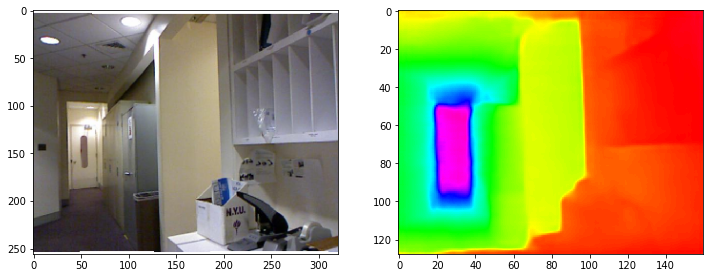

(480, 640)


In [11]:
_,depthMap = predict_img(images[11] )
print(depthMap.shape)

Use GPU: True
Loading model...
Running the image through the network...


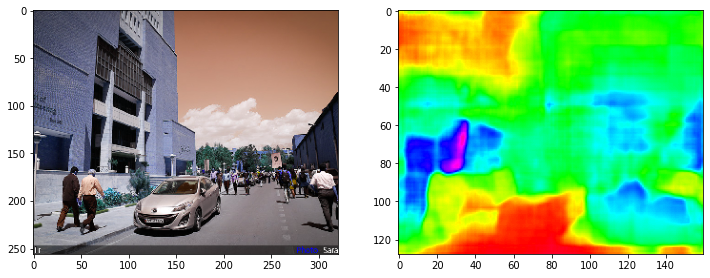

In [12]:
a = cv2.imread('/content/drive/MyDrive/DL_Project/in_images/SHARIF.jpg')
orig , pred = predict_img(a)

In [13]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 44.6/78.2 GB disk)


In [14]:
model_OD = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Saved 1 image to /content/drive/MyDrive


Use GPU: True
Loading model...
Running the image through the network...


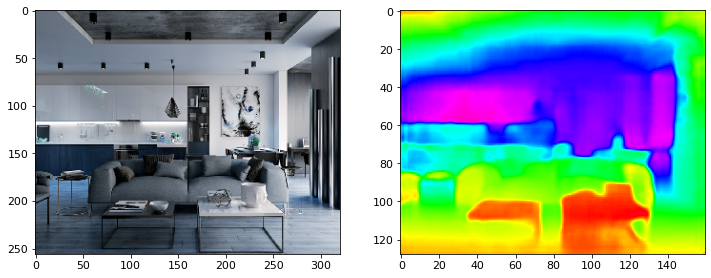

In [18]:
img = '/content/drive/MyDrive/DL_Project/in_images/indoor.jpg'
#img = images[11]
img_array = cv2.imread(img)
#img_array = img
OBJECTS = model_OD(img)
df_OD = OBJECTS.pandas().xyxy[0]
OBJECTS.save(save_dir='/content/drive/MyDrive/')
orig , pred = predict_img(img_array)

In [19]:
DEPTHS=[]

for index, row in df_OD.iterrows():
  object_depth = DEPTH_Calc(row['xmin'],row['ymin'],row['xmax'],row['ymax'])
  DEPTHS.append(round(object_depth,2))

df_OD['depth'] = DEPTHS
df_OD

df_OD.sort_values('depth' , ascending= False)

,xmin,ymin,xmax,ymax,confidence,class,name,depth
5,789.993591,353.533539,824.314514,393.903320,0.493485,58,potted plant,7.22
7,790.558838,355.877594,823.830872,395.173218,0.265084,75,vase,7.20
6,1.719799,50.076191,172.024841,537.172119,0.443728,58,potted plant,5.60
0,1102.964600,416.092712,1234.176758,566.670959,0.839130,56,chair,4.92
3,25.277760,448.807495,232.285339,656.253967,0.696508,56,chair,3.92
1,350.451904,409.039062,890.171265,559.175476,0.773057,57,couch,3.86
2,509.859924,544.446167,563.990845,578.106567,0.714041,45,bowl,2.49
4,400.036499,545.248413,491.680969,573.408875,0.569688,73,book,2.38
